In [0]:

# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

100% 12.0G/12.0G [04:53<00:00, 34.1MB/s]
100% 12.0G/12.0G [04:53<00:00, 43.8MB/s]


In [0]:
import os
import zipfile
!mkdir /content/input
!mkdir /content/input/rice-diseases-image-dataset
os.chdir('/content/input/rice-diseases-image-dataset')
zip_ref = zipfile.ZipFile('/content/rice-diseases-image-dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost.core     import XGBoostError
from lightgbm.sklearn import LightGBMError

Using TensorFlow backend.


In [0]:
epochs = 12
initLearningRate = 0.001
batchSize = 32
defaultImageSize = tuple((128, 128))
imageSize = 0
directoryRoot = '/content/input/rice-diseases-image-dataset/LabelledRice/'
width = 128
height = 128
depth = 3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, defaultImageSize)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    root_dir = listdir(directoryRoot)
    print("[INFO] Loading images ...")
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directoryRoot}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directoryRoot}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directoryRoot}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Healthy ...
[INFO] Processing Hispa ...
[INFO] Processing LeafBlast ...
[INFO] Processing BrownSpot ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)
print(image_size)

3355


In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.30, random_state = 42) 

[INFO] Spliting data to train, test


In [0]:
aug = ImageDataGenerator(
    rotation_range=45, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, 
    zoom_range=0.4, horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [0]:
opt = Adam(lr=initLearningRate, decay=initLearningRate / epochs)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=batchSize),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train),
    epochs=epochs, verbose=1
)

Epoch 1/12
2348/2348 [==============================] - 302s 129ms/step - loss: 0.5161 - accuracy: 0.7633 - val_loss: 0.4846 - val_accuracy: 0.7689
Epoch 2/12
2348/2348 [==============================] - 303s 129ms/step - loss: 0.4485 - accuracy: 0.7911 - val_loss: 0.4193 - val_accuracy: 0.8178
Epoch 3/12
2348/2348 [==============================] - 289s 123ms/step - loss: 0.3655 - accuracy: 0.8368 - val_loss: 0.4240 - val_accuracy: 0.8255
Epoch 4/12
2348/2348 [==============================] - 283s 120ms/step - loss: 0.3072 - accuracy: 0.8662 - val_loss: 0.4833 - val_accuracy: 0.8123
Epoch 5/12
2348/2348 [==============================] - 282s 120ms/step - loss: 0.2641 - accuracy: 0.8877 - val_loss: 0.4308 - val_accuracy: 0.8416
Epoch 6/12
2348/2348 [==============================] - 280s 119ms/step - loss: 0.2289 - accuracy: 0.9036 - val_loss: 0.4006 - val_accuracy: 0.8513
Epoch 7/12
2348/2348 [==============================] - 280s 119ms/step - loss: 0.1985 - accuracy: 0.9177 - val_

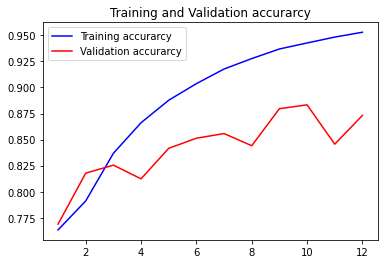

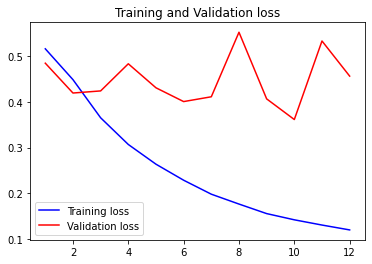

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1007/1007 [==============================] - 1s 724us/step
Test Accuracy: 87.31380105018616


In [0]:
model.save_weights('/content/categorical_model_weight_2')
model.save('/content/categorical_model_2')

In [0]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/categorical_model_2')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/content/categorical_model_2.tflite', "wb").write(tflite_model)

53608072